In [1]:
import os, cv2, sys
import numpy as np
#
from PIL import Image
from src.imgproc import loadImage
from src.model import preprocessing
from src.postprocessing import postprocess
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# define and check result folder (whether it is existed or not)
result_folder = './results/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

In [4]:
# define device id & model path
device_id = 0
model_path = "./model/craft.om"

# define image path & threshold values
poly=True
img_path = "../../Common/data/brands.jpg"
threshold_dict = {"text_threshold":0.7, "link_threshold":0.4, "low_text":0.4}


In [5]:
# initialize acllite library
acl_resource = AclLiteResource(device_id)
acl_resource.init()
print('[Device] NPU Device id:',acl_resource.device_id)
# load *.om model
model = AclLiteModel(model_path)

init resource stage:
Init resource success
[Device] NPU Device id: 0
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 1884160
malloc output 1, size 30146560
Create model output dataset success
Init model resource success


In [6]:
# read image
img_org_bgr = cv2.imread(img_path)

In [7]:
# 1) preprocessing
data, ratio_h, ratio_w = preprocessing(img_path,model._model_desc)

model input size 1
input  0
model input dims ({'name': 'input.1', 'dimCount': 4, 'dims': [1, 3, 736, 1280]}, 0)
model input datatype 0
model output size 2
output  0
model output dims ({'name': 'PartitionedCall_Transpose_136_Transpose_56:0:291', 'dimCount': 4, 'dims': [1, 368, 640, 2]}, 0)
model output datatype 0
[Model] class Model init resource stage success
[PreProc] image_np_expanded shape: (1, 3, 736, 1280)


In [8]:
%timeit -n 10 -r 3
result_list = model.execute([data,]) # 2) model execution(forward) stage

In [9]:
# get results
y = result_list[0] # output_layer_index_0
score_text = y[0,:,:,0]
score_link = y[0,:,:,1]

In [10]:
# 3) postprocessing
score_text,bboxes,polys = postprocess(threshold_dict, score_link, score_text, poly, ratio_h, ratio_w)

res_img = loadImage(img_path)

In [11]:
# save score text
filename, file_ext = os.path.splitext(os.path.basename(img_path))
mask_file = result_folder + "/res_" + filename + '_mask.jpg'
cv2.imwrite(mask_file, score_text)

True

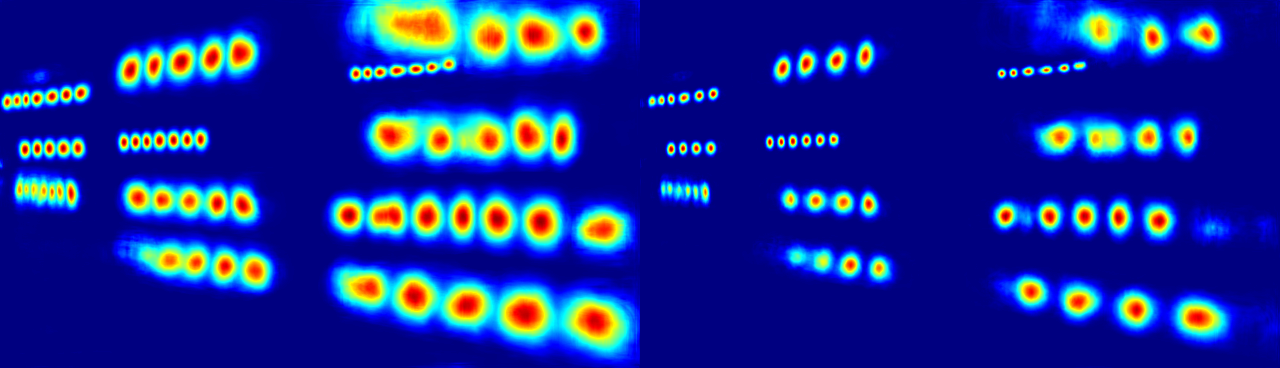

In [12]:
# show score text
score_img = cv2.cvtColor(score_text, cv2.COLOR_BGR2RGB)
score_img_plw = Image.fromarray(score_img)
score_img_plw

In [13]:
#  save result file
res_file = result_folder + "res_" + filename + '.txt'
res_img_file = result_folder + "res_" + filename + '.jpg'

res_img = cv2.imread(img_path)

with open(res_file, 'w') as f:
    for i, poly in enumerate(polys):
        poly = np.array(poly).astype(np.int32).reshape((-1))
        strResult = ','.join([str(p) for p in poly]) + '\r\n'
        f.write(strResult)
        
        poly = poly.reshape(-1, 2)
        cv2.polylines(res_img, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)

cv2.imwrite(res_img_file, res_img)

True

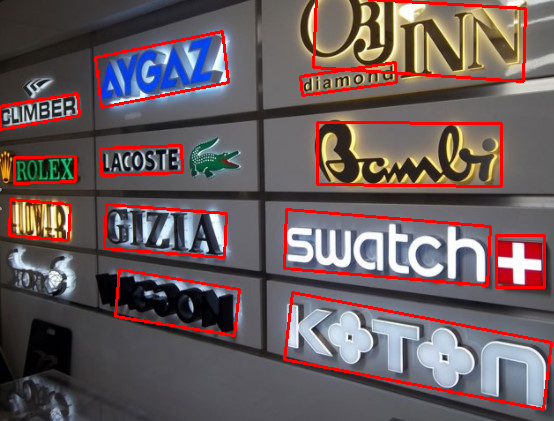

In [14]:
# show score text
res_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)
res_img_plw = Image.fromarray(res_img)
res_img_plw